# load library

In [1]:
source("r/jupyter_common.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(data.table))

# single cell analysis
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(ArchR))


# parameters

In [3]:
str_condition <- "male-bc"

args <- list()
args$cancer_type <- "male-bc"
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$harmony_theta <- 0

str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

if (args$harmony_theta >= 0) {
    str_column_of_meta_data_cluster <- str_column_of_meta_data_harmony
    str_reduction <- "harmony"
    str_umap_reduction <- "umapharmony"
    col_cluster_types <- "cluster.type.harmony"
}


str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types

figure_format <- "pdf"



[1] "RNA_harmony_th.0"

[1] "umapharmony"

[1] "cluster.type.harmony"

## set.seed

In [4]:
# set seed for reproducibility
set.seed(51)



## display

In [5]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)



# read scRNA-seq DEGs

In [6]:
fname_dge <- "tsv/male-bc_er+bc-epi_er+bc_vs_male-bc.tsv"

df_dge <- read.table(fname_dge, header = TRUE, as.is = TRUE, row.names = 1)
head(df_dge)
dim(df_dge)

min(df_dge$p_val_adj)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS4Y1,1.655515e-174,2.313585,0.948,0.000,4.144417e-170,0,1.459589,2.984242
TNFRSF12A,3.075781e-164,2.987610,0.997,0.270,7.699909e-160,0,2.620978,4.394236
ISG20,3.978188e-146,2.525560,0.945,0.118,9.958995e-142,0,1.751471,3.843429
S100A6,2.320176e-145,3.401509,1.000,0.574,5.808329e-141,0,4.662926,6.206801
LGALS3,2.298172e-142,2.358381,0.997,0.445,5.753244e-138,0,2.710801,4.376743
SLC3A2,1.997836e-141,2.358616,0.995,0.296,5.001382e-137,0,2.079425,4.490780


[1] 1018    8

[1] 4.144417e-170

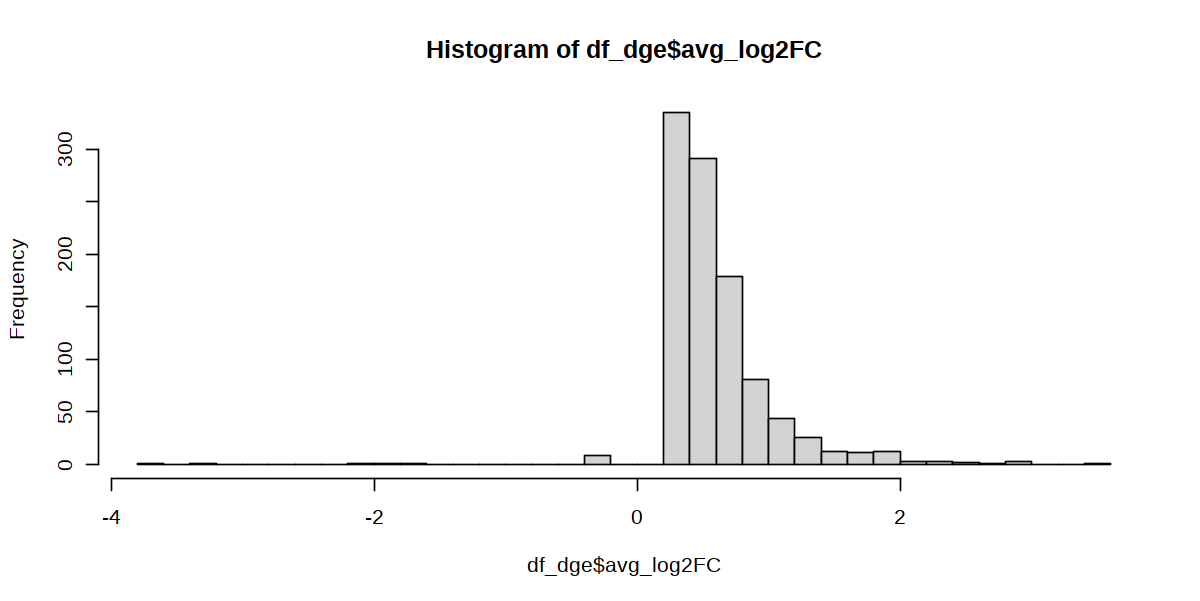

In [7]:
options(repr.plot.width=10, repr.plot.height=5.01)
hist(df_dge$avg_log2FC, 30)


# overlap with p2g.df.sub.plot.cancer_specific

## load p2g.df.sub.plot.cancer_specific

In [8]:
peaktype <- "enhancer"

dir_atac <- "/home/hkim77/francolab.w/sc-atac-seq/male-bc/run-20220725"
dir_output <- sprintf("%s/output_male-bc", dir_atac)
dir_output_p2g <- sprintf("%s/output_p2g_male-bc", dir_atac)

fname_rds <- sprintf("%s/rds/cancer_specific_%s_p2g_table.rds", dir_output_p2g, peaktype)

p2g.df.sub.plot.cancer_specific <- readRDS(fname_rds)
head(p2g.df.sub.plot.cancer_specific)
dim(p2g.df.sub.plot.cancer_specific)

n_p2g.cancer_specific <- nrow(p2g.df.sub.plot.cancer_specific)
var <- sprintf("n_p2g.%s.cancer_specific", peaktype)
cat(sprintf("\t%s: %d\n", var, n_p2g.cancer_specific))

n_peaks.p2g.cancer_specific <- length(unique(p2g.df.sub.plot.cancer_specific$idxATAC))
var <- sprintf("n_peaks.p2g.%s.cancer_specific", peaktype)
cat(sprintf("\t%s: %d\n", var, n_peaks.p2g.cancer_specific))


,idxATAC,idxRNA,Correlation,FDR,VarQATAC,VarQRNA,EmpPval,EmpFDR,geneName,peakName,peakType,idx,kmeans
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,29,3,0.5394961,6.024423e-38,0.9396097,0.4338114,0.11278982,0.7965846,FAM41C,chr1:1079324-1079824,Distal,29-3,5
2,24,7,0.7894052,5.401495e-105,0.7539227,0.5385226,0.01994288,0.7892789,PLEKHN1,chr1:1068557-1069057,Distal,24-7,5
3,25,7,0.7349978,6.699672e-84,0.7787057,0.5385226,0.03031435,0.7892789,PLEKHN1,chr1:1069078-1069578,Distal,25-7,2
4,26,7,0.8462787,5.132060e-135,0.7508486,0.5385226,0.01255312,0.7892789,PLEKHN1,chr1:1069752-1070252,Distal,26-7,2
5,29,7,0.8539726,5.278697e-140,0.9396097,0.5385226,0.01176771,0.7892789,PLEKHN1,chr1:1079324-1079824,Distal,29-7,5
6,30,7,0.6868139,3.617362e-69,0.4759030,0.5385226,0.04307672,0.7892789,PLEKHN1,chr1:1080052-1080552,Distal,30-7,5


[1] 11551    13

	n_p2g.enhancer.cancer_specific: 11551
	n_peaks.p2g.enhancer.cancer_specific: 5141


## df_dge.cse

In [9]:
f <- rownames(df_dge) %in% p2g.df.sub.plot.cancer_specific$geneName

df_dge.cse <- df_dge[f,]

head(df_dge.cse)
dim(df_dge.cse)



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ISG20,3.978188e-146,2.525560,0.945,0.118,9.958995e-142,0.0000000,1.751471,3.843429
S100A6,2.320176e-145,3.401509,1.000,0.574,5.808329e-141,0.0000000,4.662926,6.206801
SAT1,8.599381e-139,2.803190,1.000,0.667,2.152769e-134,0.2981702,3.742109,5.598026
MYL12A,1.249291e-130,2.150761,0.998,0.570,3.127474e-126,0.0000000,2.650992,4.167212
PPP1R14B,8.975878e-129,1.897139,0.995,0.375,2.247021e-124,0.0000000,2.040378,3.449861
ANXA2,7.186044e-128,1.925806,0.999,0.668,1.798954e-123,0.0000000,2.983556,4.697529


[1] 363   8

### write.table

In [10]:
write.table(df_dge.cse, 
   file="tsv/df_dge.cse.tsv",
   row.names = T, col.names = T, quote = F, sep = "\t")


## p2g_genes_female_vs_male.cse

In [11]:
f <- (abs(df_dge.cse$avg_log2FC) > 1.0 & df_dge.cse$p_val_adj < 0.01)
p2g_genes_female_vs_male.cse <- rownames(df_dge.cse[f,])
p2g_genes_female_vs_male.cse
print(length(p2g_genes_female_vs_male.cse))

if (length(p2g_genes_female_vs_male.cse) < 5) {
    p2g_genes_female_vs_male.cse <- rownames(df_dge.cse)
    print(p2g_genes_female_vs_male.cse)
    print(length(p2g_genes_female_vs_male.cse))
}


[1] "ISG20"    "S100A6"   "SAT1"     "MYL12A"   "PPP1R14B" "ANXA2"   
 [7] "MYL12B"   "TKT"      "HSPB8"    "S100A16"  "PIM3"     "NAA20"   
[13] "SH3BGRL3" "SQOR"     "FHL2"     "LAMB3"    "CAPN2"    "TALDO1"  
[19] "CLTB"     "PFKP"     "USP53"    "PHLDA2"   "SLC39A1"  "CD47"    
[25] "NDUFV2"   "PAWR"     "PPIF"     "BAG1"     "CSRP1"    "SLK"     
[31] "CLIP1"    "MYH9"     "C1QBP"    "MGLL"     "ZNF706"   "PHLDA3"  
[37] "PRDX4"    "S100A14"  "HES4"     "GNAS"     "SFN"      "VDAC2"   
[43] "GTF2A2"   "TMEM40"   "MGST1"    "FABP3"    "CCT3"     "FSTL3"   
[49] "METRN"    "TUBB4B"   "ACTN1"    "TACSTD2"  "FBXO32"   "SPTSSA"  
[55] "KRT23"    "GDF15"    "SERPINA1" "WFDC2"    "YWHAZ"    "KRT7"    
[61] "TPM1"

[1] 61


## genes_of_interest

In [12]:
genes_for_label <- c("ANXA2", "LAMB3", "SAT1", "S100A6",
                     "CSRP1",
                     "PRDX4",
                     "TMEM40",
                     "FABP3",
                     "KRT23")


## volcanoplot

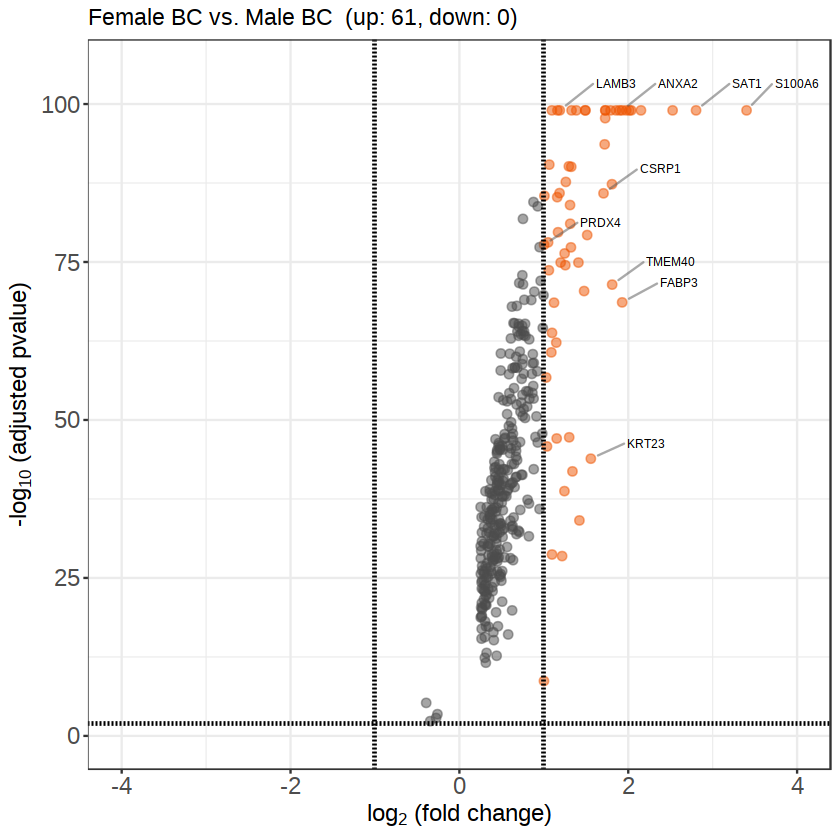

In [13]:

gg <- get_volcano_plot(df_dge.cse,
                       th_log2fc = 1.0,
                       th_padj = 0.01,
                       str_condition = "Female BC vs. Male BC",
                       label.select = genes_for_label,
                       col_log2fc = "avg_log2FC",
                       col_padj = "p_val_adj")

str_condition_tmp <- sprintf("%s_sc-rna-seq_female-bc-vs-male-bc.enhancer_overlap", str_condition)
filename <- sprintf("volcanoplot_%s", str_condition_tmp)
print_figure(gg, width=7, height=7, file=filename)



## check genes

In [14]:
genes <- c("PRDX4", "ANXA2", "LAMB3")

df_dge[genes,]
df_dge.cse[genes,]


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PRDX4,7.475931e-83,1.003037,0.953,0.334,1.871525e-78,0,1.262914,2.857949
ANXA2,7.186044e-128,1.925806,0.999,0.668,1.798954e-123,0,2.983556,4.697529
LAMB3,1.040945e-107,1.189003,0.693,0.019,2.605902e-103,0,0.686677,3.027851


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PRDX4,7.475931e-83,1.003037,0.953,0.334,1.871525e-78,0,1.262914,2.857949
ANXA2,7.186044e-128,1.925806,0.999,0.668,1.798954e-123,0,2.983556,4.697529
LAMB3,1.040945e-107,1.189003,0.693,0.019,2.605902e-103,0,0.686677,3.027851


# session info

In [15]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

